In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factors
import observation_models
import state_models
from ssm_em import StateSpaceEM

# Generate some data 

Here we generate some simple data, with some sines and additive Gaussian noise.

In [9]:
def proj(U, v):
    return numpy.dot(numpy.dot(v, U) / numpy.linalg.norm(U, axis=0), U.T)

def gs(N):
    V = numpy.zeros((N, N))
    A = numpy.random.randn(N,N)
    #A = numpy.eye(N)
    for d in range(N):
        v = A[:,d]
        V[:,d] = v - proj(V[:,:d], v)
        V[:,d] /= numpy.sqrt(numpy.sum(V[:,d] ** 2))
    return V


def generate_heteroscedastic_data(T, Dx, Dz, Du, sigma_z = .02, sigma_x = .02):
    params_dict = {'T': T, 'Dx': Dx, 'Dz': Dz, 'Du': Du, 'sigma_z': sigma_z, 'sigma_x': sigma_x}
    C = numpy.random.randn(Dx, Dz)
    C /= numpy.sum(C, axis=0)[None] * .5
    U = gs(Dx)[:Du].T
    w = 2 * numpy.random.randn(Du, Dz)
    #w /=  numpy.sum(numpy.abs(w), axis=1)[:,None]
    b_w = numpy.random.randn(Du)
    beta = 1e-2 * numpy.random.rand(Du)
    params_dict = {**params_dict, 'C': C, 'U': U, 'w': w, 'b_w': b_w, 'beta': beta}
    
    # Sample latent space
    z = numpy.zeros([Dz, T])
    noise_z = sigma_z * numpy.random.randn(Dz, T)
    # A = .99 * numpy.eye(Dz)
    # A[1,0] = .05
    # A[0,1] = -.05
    # b = numpy.zeros(Dz)
    # for t in range(1,T):
    #     z[:,t] = numpy.dot(A, z[:,t-1]) + b + noise_z[:,t-1]
    freq = 1 / (1000 * numpy.random.rand(Dz) + 500)
    phase = 2 * numpy.pi * numpy.random.rand(Dz)
    for idz in range(Dz): 
        z[idz] = 1*numpy.cos(2 * numpy.pi * numpy.arange(T) * freq[idz] + phase[idz]) + noise_z[idz]
    D_Sigma = 2 * beta[:,None] * (numpy.cosh(numpy.dot(w, z) + b_w[:,None]))
    x = numpy.zeros((Dx,T))
    mu_x = numpy.dot(C, z)
    noise_x = numpy.random.randn(Dx, T)
    for t in range(T):
        Sigma_x = sigma_x ** 2 * numpy.eye(Dx) + numpy.dot(numpy.dot(U, numpy.diag(D_Sigma[:,t])), U.T)
        L_x = numpy.linalg.cholesky(Sigma_x)
        x[:,t] = mu_x[:,t] + numpy.dot(L_x, noise_x[:,t])
    return x.T, z.T, params_dict

In [32]:
Dz = 2
Dx = 7
Du = 3
T = 4000
X, z, params_dict = generate_heteroscedastic_data(T, Dx, Dz, Du, sigma_x=.01)

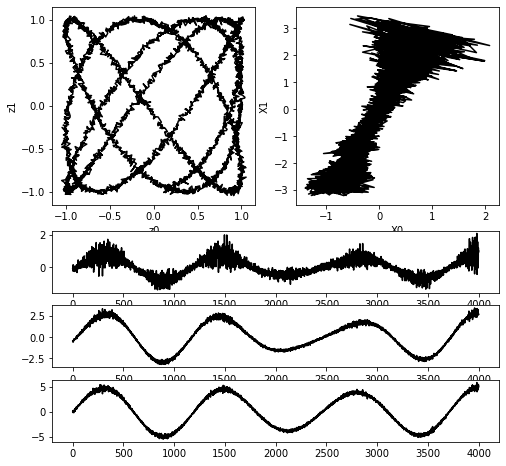

In [33]:
pyplot.figure(figsize=(8,8))
pyplot.subplot(221)
pyplot.plot(z[:,0], z[:,1], 'k')
pyplot.xlabel('z0')
pyplot.ylabel('z1')
pyplot.subplot(222)
pyplot.plot(X[:,1], X[:,2], 'k')
pyplot.xlabel('X0')
pyplot.ylabel('X1')
pyplot.subplot(614)
pyplot.plot(X[:4000,1], 'k')
pyplot.subplot(615)
pyplot.plot(X[:4000,2], 'k')
pyplot.subplot(616)
pyplot.plot(X[:4000,3], 'k')

# Linear state space model 

We fit a state space model with linear state and observation model to the data.

First we instantiate the state and observation model.

In [34]:
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz)
om.pca_init(X)

Then we give it to the EM object with the data and fit it.

Iteration 2 - llk=7992.1
Iteration 4 - llk=15500.5
Iteration 6 - llk=21117.0
Iteration 8 - llk=25706.3
Iteration 10 - llk=28959.1
Iteration 12 - llk=30884.3
Iteration 14 - llk=31652.8
Iteration 16 - llk=31840.3
Iteration 18 - llk=31900.8
Iteration 20 - llk=31932.1
Iteration 22 - llk=31949.3
Iteration 24 - llk=31958.4
EM did converge.


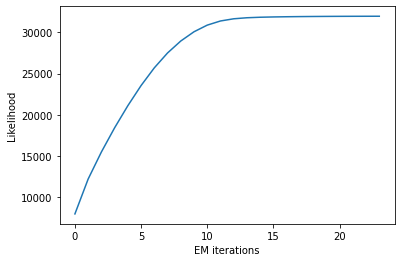

In [35]:
ssm_em_lin = StateSpaceEM(X, observation_model=om, state_model=sm)
ssm_em_lin.run()
pyplot.plot(ssm_em_lin.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

We show the data density for the training data.

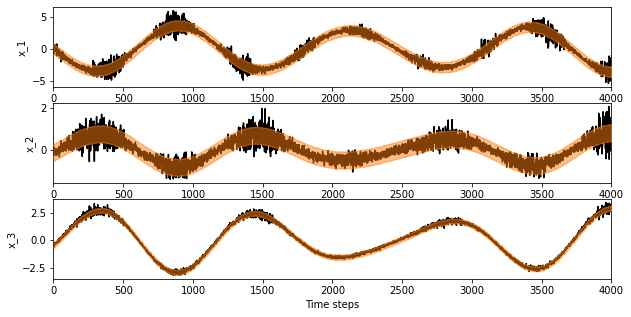

In [36]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    x_min = p_x.mu[:4000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:4000,ix,ix])
    x_max = p_x.mu[:4000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:4000,ix,ix])
    pyplot.plot(X[:4000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X[:4000].shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

We can also make predictions, when we delete parts of the data.

In [15]:
X_test = numpy.copy(X)
X_test[numpy.random.rand(*X_test.shape) < .9] = numpy.nan
filter_test, mu, std = ssm_em_lin.predict(X_test, smoothed=True)

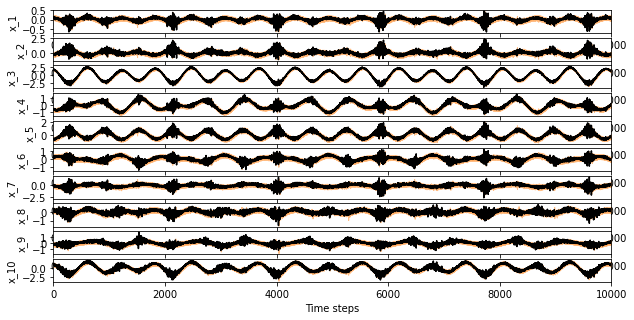

In [16]:
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

# Heteroscedastic State space model

And here we do the same again, but with linear transition model and heteroscedastic observation model.

In [43]:
Dz = 2
Du = 5
sm = state_models.LinearStateModel(Dz)
# Here we change the observation model.
om = observation_models.HCCovObservationModel(Dx, Dz, Du)
#om.pca_init(X)
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm)

In [ ]:
ssm_em.run()

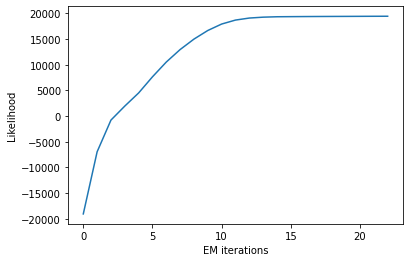

In [41]:
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

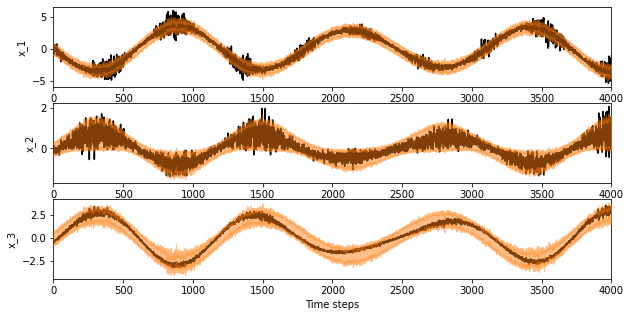

In [42]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    x_min = p_x.mu[:4000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:4000,ix,ix])
    x_max = p_x.mu[:4000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:4000,ix,ix])
    pyplot.plot(X[:4000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,4000])
pyplot.xlabel('Time steps')
pyplot.show()

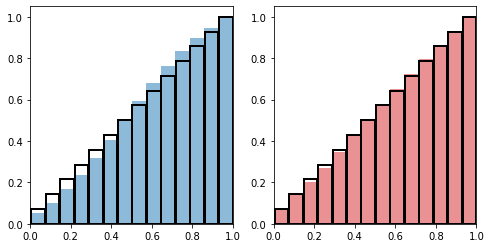

In [21]:
import scipy
idx = 3
num_bins = 15
pyplot.figure(figsize=(8,4))
pyplot.subplot(121)
p_x = ssm_em_lin.compute_data_density()
pyplot.hist(scipy.stats.norm.cdf((X[:,ix] - p_x.mu[:,ix]) / numpy.sqrt(p_x.Sigma[:,ix,ix])), density=True, bins=numpy.linspace(0,1,num_bins), alpha=.5, cumulative=True)
pyplot.bar(numpy.linspace(0,1,num_bins)-.5/num_bins, numpy.linspace(0,1,num_bins), width=1/num_bins, color='none', edgecolor='k', linewidth=2.)
pyplot.xlim([0,1])
pyplot.subplot(122)
p_x = ssm_em.compute_data_density()
pyplot.hist(scipy.stats.norm.cdf((X[:,ix] - p_x.mu[:,ix]) / numpy.sqrt(p_x.Sigma[:,ix,ix])), density=True, bins=numpy.linspace(0,1,num_bins), alpha=.5, cumulative=True, color='C3')
pyplot.bar(numpy.linspace(0,1,num_bins)-.5/num_bins, numpy.linspace(0,1,num_bins), width=1/num_bins, color='none', edgecolor='k', linewidth=2.)
pyplot.xlim([0,1])
pyplot.show()

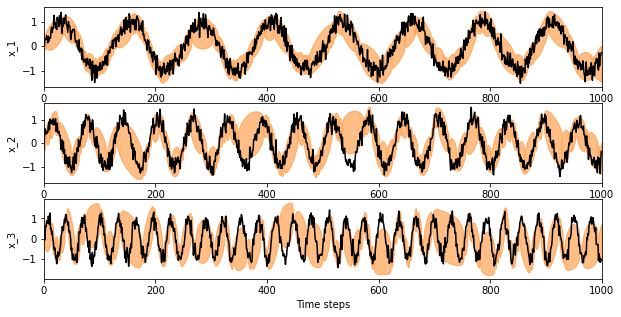

In [16]:
X_test = numpy.copy(X)
X_test[numpy.random.rand(*X_test.shape) < .9] = numpy.nan
filter_test, mu, std = ssm_em.predict(X_test, smoothed=True)
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [2]:
import h5py
import numpy
import pandas

def load_pressure_ts(experiment_name, data_path = '../data/', piv=False, field_names=None, train_ratio=1):
    f = h5py.File(data_path + experiment_name + '/%s_pressure.mat' %experiment_name, 'r')
    if field_names is None:
        field_names = ['t', 'alpha_theory', 'alpha', 'd2alphadt2', 'dalphadt', 'phase', 'beta', 'phase_beta', 'Cl', 'Cm', 'Cp', 'stgx']  
    if piv:
        field = 'piv'
    else:
        field = 'res'
    pressure_dict = {}
    for name in field_names:
        if name == 'Cp':
            num_sensors = f[field][name].shape[1]
            for isensor in range(num_sensors):
                pressure_dict['Cp%d' % isensor] = f[field][name][:, isensor]
        elif name == 'stgx':
            stgx_df = pandas.read_csv(data_path + '%s/%s_stgdata.csv' %(experiment_name, experiment_name[5:]))
            pressure_dict[name] = stgx_df['stgx'].to_numpy()
        else:
            pressure_dict[name] = numpy.squeeze(f[field][name])
    f.close()
    if train_ratio==1:
        return pandas.DataFrame(pressure_dict)
    else:
        df = pandas.DataFrame(pressure_dict)
        exp_len = df.shape[0]
        train_len = int(train_ratio * exp_len)
        train_df = df[df.keys()][:train_len]
        test_df = df[df.keys()][train_len:]
        return train_df, test_df

def load_pressure_sensor_pos(experiment_name, data_path = '../data/'):
    f = h5py.File(data_path + experiment_name + '/%s_pressure.mat' % experiment_name, 'r')
    pos_dict = {'xcp': numpy.squeeze(f['res']['xcp']), 'ycp': numpy.squeeze(f['res']['ycp'])}
    f.close()
    return pandas.DataFrame(pos_dict)

def load_exp_params(experiment_name, data_path = '../data/'):
    f = h5py.File(data_path + experiment_name + '/%s_pressure.mat' %experiment_name, 'r')
    U0, chord_length, rho = f['param']['U0'][0][0], f['param']['c'][0][0], f['param']['rho'][0][0]
    f.close()
    return U0, chord_length, rho

In [85]:
from scipy.stats import zscore
pressure_df = load_pressure_ts('ms033mpt006', data_path='../../data/')
sensor_names = ['Cp%d' %i for i in range(0,36,4)]
target_names = ['Cl', 'Cm']
all_vars = sensor_names + target_names
X = pressure_df[all_vars][::8].to_numpy()

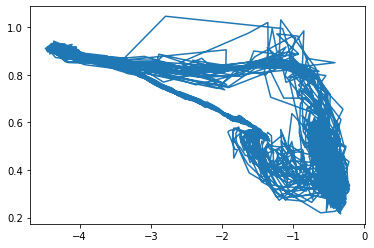

In [86]:
pyplot.plot(X[:4000,0],X[:4000,-2])

Iteration 2 - llk=14047.8
Iteration 4 - llk=16750.8
Iteration 6 - llk=19948.5
Iteration 8 - llk=22296.3
Iteration 10 - llk=23903.0
Iteration 12 - llk=24979.5
Iteration 14 - llk=25495.9
Iteration 16 - llk=25672.3
Iteration 18 - llk=25742.8
Iteration 20 - llk=25804.0
Iteration 22 - llk=25854.5
EM did converge.


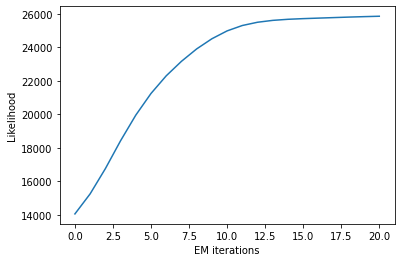

In [91]:
Dz = 11
Dx = X.shape[1]
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz)
#om.pca_init(X[:2000])
ssm_em_lin = StateSpaceEM(X[:1000], observation_model=om, state_model=sm, conv_crit=1e-3)
ssm_em_lin.run()
pyplot.plot(ssm_em_lin.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

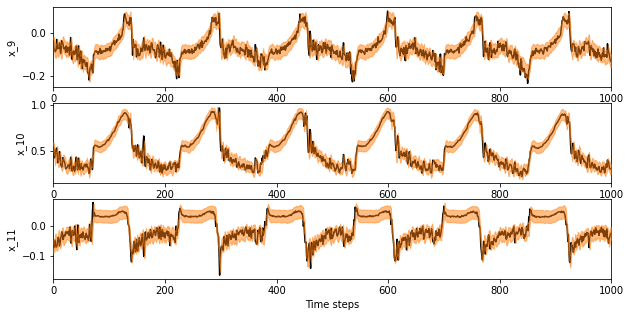

In [88]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    ix += 8
    x_min = p_x.mu[:1000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    x_max = p_x.mu[:1000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    pyplot.plot(X[:1000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X[:1000].shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [89]:
Du = 8
Dz = 11
sm = state_models.LinearStateModel(Dz)
# Here we change the observation model.
om = observation_models.HCCovObservationModel(Dx, Dz, Du)
#om.pca_init(X[:1000])

In [90]:
ssm_em = StateSpaceEM(X[:1000], observation_model=om, state_model=sm, conv_crit=1e-4)
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

Iteration 2 - llk=1969.7
Iteration 4 - llk=11524.0
Iteration 6 - llk=18995.5
Iteration 8 - llk=21772.0


KeyboardInterrupt: 

In [ ]:
pyplot.plot(ssm_em.llk_list[:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

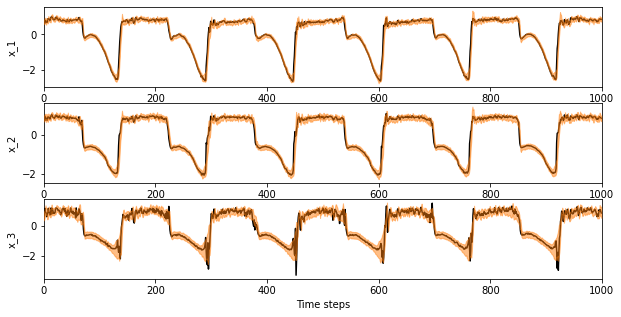

In [79]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    ix += 0
    x_min = p_x.mu[:1000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    x_max = p_x.mu[:1000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    pyplot.plot(X[:1000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X[:1000].shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [80]:
ssm_em.compute_predictive_log_likelihood(X[2000:10000])

56312.723297496275

In [72]:
ssm_em_lin.compute_predictive_log_likelihood(X[2000:10000])

43182.92134113578

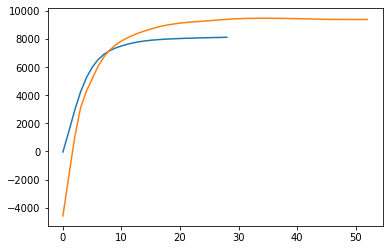

In [66]:
pyplot.plot(ssm_em_lin.llk_list[1:])
pyplot.plot(ssm_em.llk_list[1:])

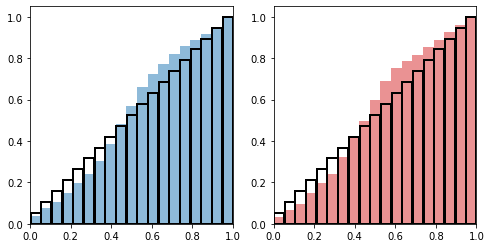

In [84]:
import scipy
ix = 9
num_bins = 20
pyplot.figure(figsize=(8,4))
pyplot.subplot(121)
p_x = ssm_em_lin.compute_data_density()
pyplot.hist(scipy.stats.norm.cdf((X[:1000,ix] - p_x.mu[:,ix]) / numpy.sqrt(p_x.Sigma[:,ix,ix])), density=True, bins=numpy.linspace(0,1,num_bins), alpha=.5, cumulative=True)
pyplot.bar(numpy.linspace(0,1,num_bins)-.5/num_bins, numpy.linspace(0,1,num_bins), width=1/num_bins, color='none', edgecolor='k', linewidth=2.)
pyplot.xlim([0,1])
pyplot.subplot(122)
p_x = ssm_em.compute_data_density()
pyplot.hist(scipy.stats.norm.cdf((X[:1000,ix] - p_x.mu[:,ix]) / numpy.sqrt(p_x.Sigma[:,ix,ix])), density=True, bins=numpy.linspace(0,1,num_bins), alpha=.5, cumulative=True, color='C3')
pyplot.bar(numpy.linspace(0,1,num_bins)-.5/num_bins, numpy.linspace(0,1,num_bins), width=1/num_bins, color='none', edgecolor='k', linewidth=2.)
pyplot.xlim([0,1])
pyplot.show()

## Airquality

In [40]:
aq_df = pandas.read_excel('../../data/airquality_UCI/AirQualityUCI.xlsx')

array([   0,    1,    2, ..., 9354, 9355, 9356])

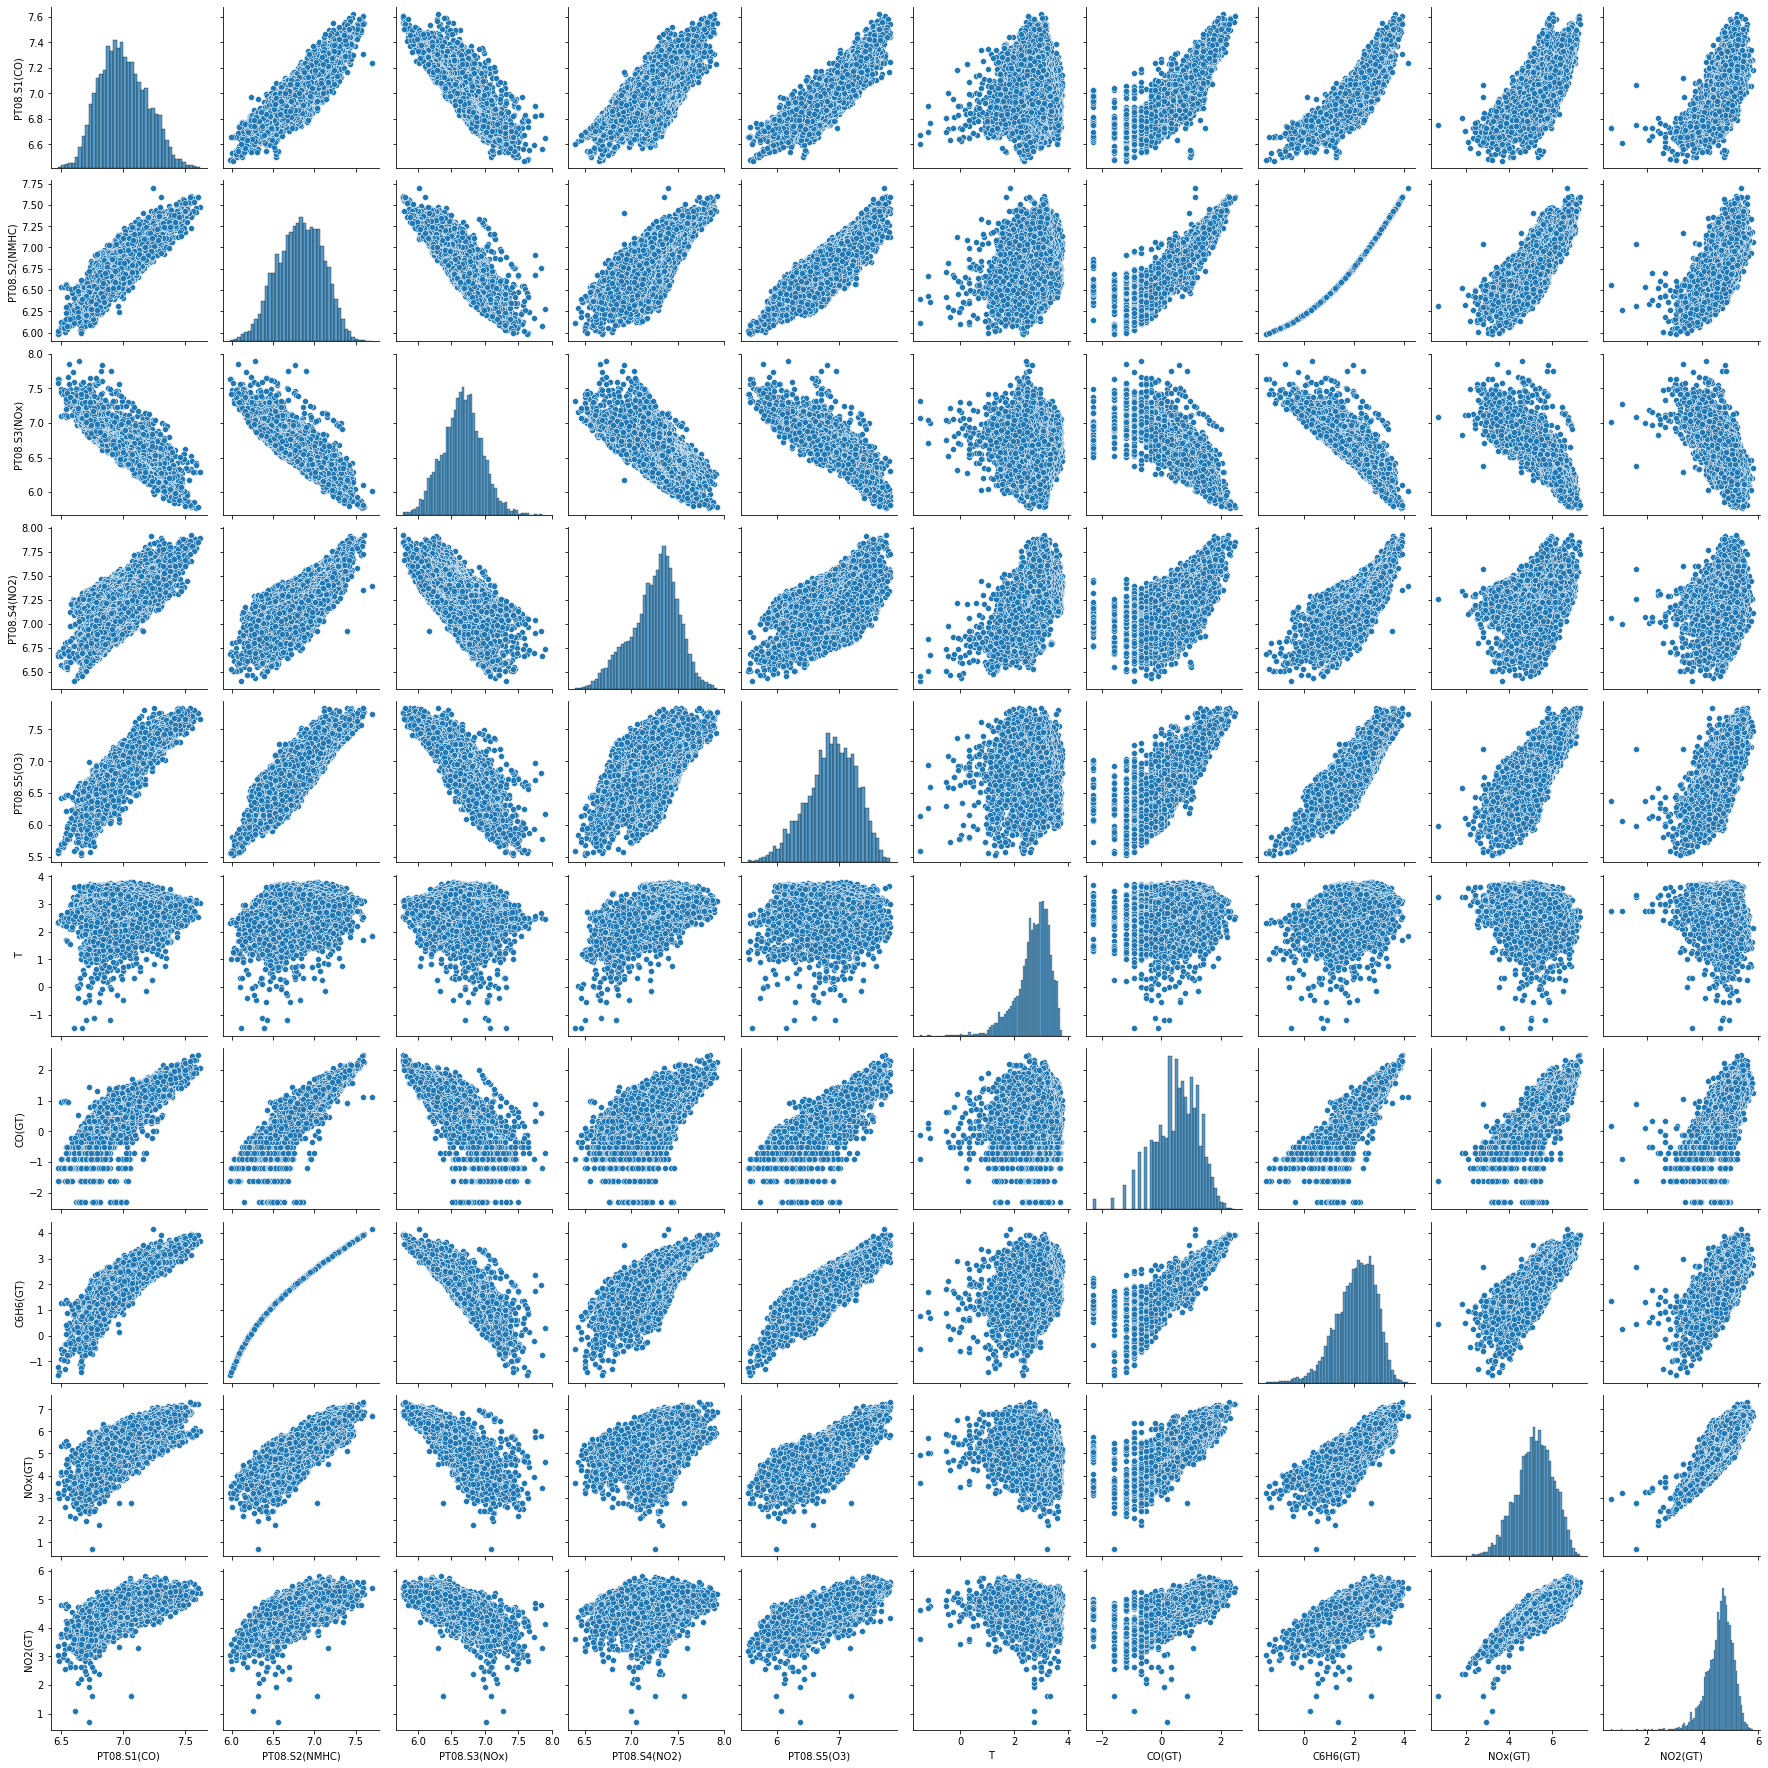

In [42]:
sensor_names = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
control_vars = ['T']
target_names = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
all_vars = sensor_names + control_vars + target_names
import seaborn
seaborn.pairplot(numpy.log(aq_df[all_vars][numpy.all(aq_df[all_vars] > 0, axis=1)]))

In [ ]:
import sea

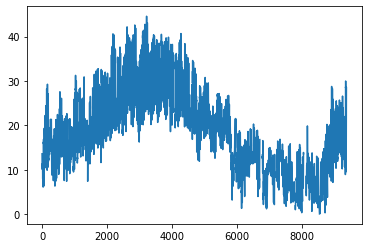

In [301]:
sensor_names = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
control_vars = ['T']
target_names = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
pyplot.plot(aq_df[control_vars][aq_df[control_vars] > 0].to_numpy())

In [44]:
X.shape

(6941, 4)

In [43]:
X = aq_df[target_names].to_numpy()
X = numpy.log(X[numpy.all(X > 0, axis=1)])
X = zscore(X)

Iteration 2 - llk=-1207.2
Iteration 4 - llk=-924.2
Iteration 6 - llk=-838.6
Iteration 8 - llk=-751.9
Iteration 10 - llk=-678.8
Iteration 12 - llk=-618.1
Iteration 14 - llk=-559.3
Iteration 16 - llk=-477.6
Iteration 18 - llk=-315.4
Iteration 20 - llk=-121.8
Iteration 22 - llk=-5.4
Iteration 24 - llk=60.4
Iteration 26 - llk=104.4
Iteration 28 - llk=139.1
Iteration 30 - llk=168.9
Iteration 32 - llk=195.4
Iteration 34 - llk=218.9
Iteration 36 - llk=239.6
Iteration 38 - llk=257.5
Iteration 40 - llk=272.4
Iteration 42 - llk=284.6
Iteration 44 - llk=294.2
Iteration 46 - llk=301.7
Iteration 48 - llk=307.5
Iteration 50 - llk=312.0
Iteration 52 - llk=315.5
Iteration 54 - llk=318.3
Iteration 56 - llk=320.5
Iteration 58 - llk=322.3
Iteration 60 - llk=323.9
Iteration 62 - llk=325.1
Iteration 64 - llk=326.2
Iteration 66 - llk=327.2
Iteration 68 - llk=328.0
Iteration 70 - llk=328.8
Iteration 72 - llk=329.5
EM did converge.


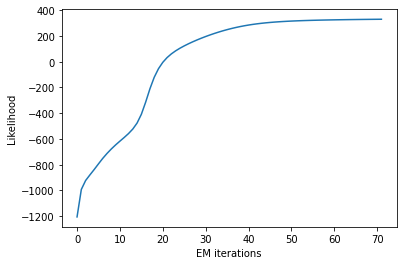

In [45]:
Dz = 4
Dx = X.shape[1]
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x=.1)
om.pca_init(X[:1000])
ssm_em_lin = StateSpaceEM(X[:1000], observation_model=om, state_model=sm, conv_crit=1e-3)
ssm_em_lin.run()
pyplot.plot(ssm_em_lin.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

In [290]:
X.shape

(320, 7)

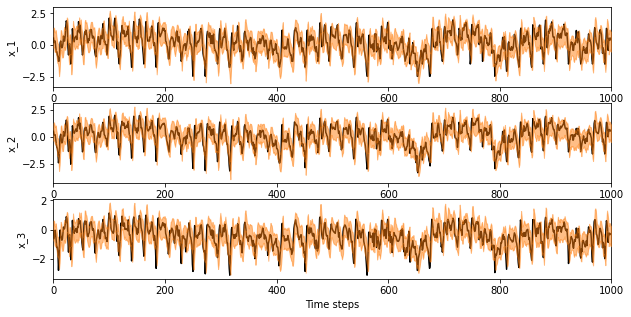

In [46]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    ix += 0
    x_min = p_x.mu[:1000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    x_max = p_x.mu[:1000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    pyplot.plot(X[:1000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X[:1000].shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [47]:
Du = 2
Dz = 4
sm = state_models.LinearStateModel(Dz)
# Here we change the observation model.
om = observation_models.HCCovObservationModel(Dx, Dz, Du)
om.pca_init(X[:1000])

Iteration 2 - llk=-796.5
Iteration 4 - llk=-565.2
Iteration 6 - llk=-444.9
Iteration 8 - llk=-254.5
Iteration 10 - llk=1.9
Iteration 12 - llk=117.7
Iteration 14 - llk=174.3
Iteration 16 - llk=213.6
Iteration 18 - llk=244.5
Iteration 20 - llk=269.9
Iteration 22 - llk=290.9
Iteration 24 - llk=308.1
Iteration 26 - llk=322.2
Iteration 28 - llk=333.6
Iteration 30 - llk=343.2
Iteration 32 - llk=351.6
Iteration 34 - llk=359.1
Iteration 36 - llk=365.9
Iteration 38 - llk=371.6
Iteration 40 - llk=376.2
Iteration 42 - llk=380.1
Iteration 44 - llk=382.7
Iteration 46 - llk=385.0
Iteration 48 - llk=387.0
Iteration 50 - llk=388.6
Iteration 52 - llk=390.2
Iteration 54 - llk=391.7
Iteration 56 - llk=393.0
Iteration 58 - llk=394.3
Iteration 60 - llk=395.6
Iteration 62 - llk=396.8
Iteration 64 - llk=397.9
Iteration 66 - llk=399.1
Iteration 68 - llk=400.1
Iteration 70 - llk=401.1
Iteration 72 - llk=402.1
Iteration 74 - llk=403.0
EM did converge.


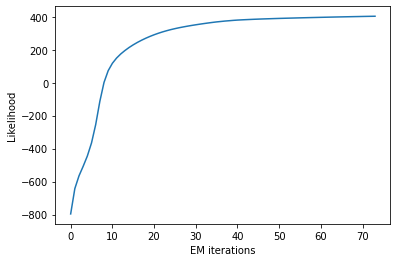

In [48]:
ssm_em = StateSpaceEM(X[:1000], observation_model=om, state_model=sm, conv_crit=1e-3)
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

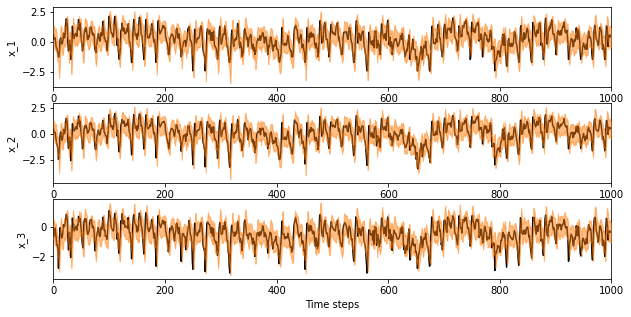

In [49]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    ix += 0
    x_min = p_x.mu[:1000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    x_max = p_x.mu[:1000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    pyplot.plot(X[:1000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X[:1000].shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [50]:
ssm_em.compute_predictive_log_likelihood(X[1000:10000])

-63752.494897468576

In [51]:
ssm_em_lin.compute_predictive_log_likelihood(X[1000:10000])

-82939.26040071563

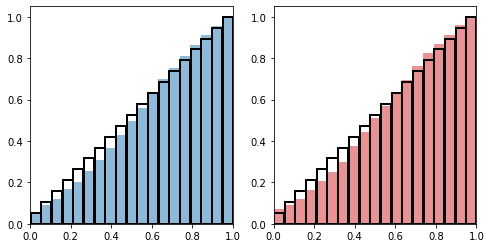

In [55]:
import scipy
ix = 3
num_bins = 20
pyplot.figure(figsize=(8,4))
pyplot.subplot(121)
p_x = ssm_em_lin.compute_data_density()
pyplot.hist(scipy.stats.norm.cdf((X[:1000,ix] - p_x.mu[:,ix]) / numpy.sqrt(p_x.Sigma[:,ix,ix])), density=True, bins=numpy.linspace(0,1,num_bins), alpha=.5, cumulative=True)
pyplot.bar(numpy.linspace(0,1,num_bins)-.5/num_bins, numpy.linspace(0,1,num_bins), width=1/num_bins, color='none', edgecolor='k', linewidth=2.)
pyplot.xlim([0,1])
pyplot.subplot(122)
p_x = ssm_em.compute_data_density()
pyplot.hist(scipy.stats.norm.cdf((X[:1000,ix] - p_x.mu[:,ix]) / numpy.sqrt(p_x.Sigma[:,ix,ix])), density=True, bins=numpy.linspace(0,1,num_bins), alpha=.5, cumulative=True, color='C3')
pyplot.bar(numpy.linspace(0,1,num_bins)-.5/num_bins, numpy.linspace(0,1,num_bins), width=1/num_bins, color='none', edgecolor='k', linewidth=2.)
pyplot.xlim([0,1])
pyplot.show()

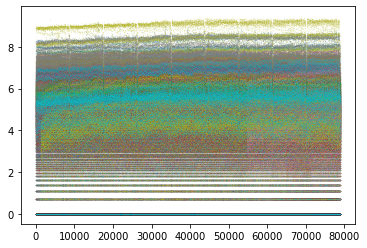

In [415]:
from pyro.contrib.examples.bart import load_bart_od
bart_data = load_bart_od()
data = bart_data["counts"].sum([-1]).log1p()
#data = bart_data["counts"].sum([-1]).unsqueeze(-1).log1p()
pyplot.plot(data, '.', ms=.1)

In [429]:
data.numpy()

array([[4.317488 , 5.7525725, 4.7184987, ..., 3.4011974, 0.       ,
        3.9318256],
       [4.934474 , 6.7093043, 6.5467854, ..., 3.7612002, 0.       ,
        3.6635616],
       [4.934474 , 7.1228666, 5.7776523, ..., 3.8286414, 0.       ,
        3.912023 ],
       ...,
       [5.09375  , 5.4764633, 5.0369525, ..., 4.882802 , 4.744932 ,
        5.32301  ],
       [5.0875964, 5.3375382, 5.0689044, ..., 5.209486 , 4.9767337,
        5.420535 ],
       [4.5217886, 5.4553213, 5.117994 , ..., 4.4308167, 4.0073333,
        5.209486 ]], dtype=float32)

In [483]:
bart_df = pandas.DataFrame(data.numpy(), columns=bart_data['stations'])

In [484]:
criteria = ((bart_df[:1000] == 0).mean(axis=0) < .3)
bart_df = bart_df[criteria[criteria].index]

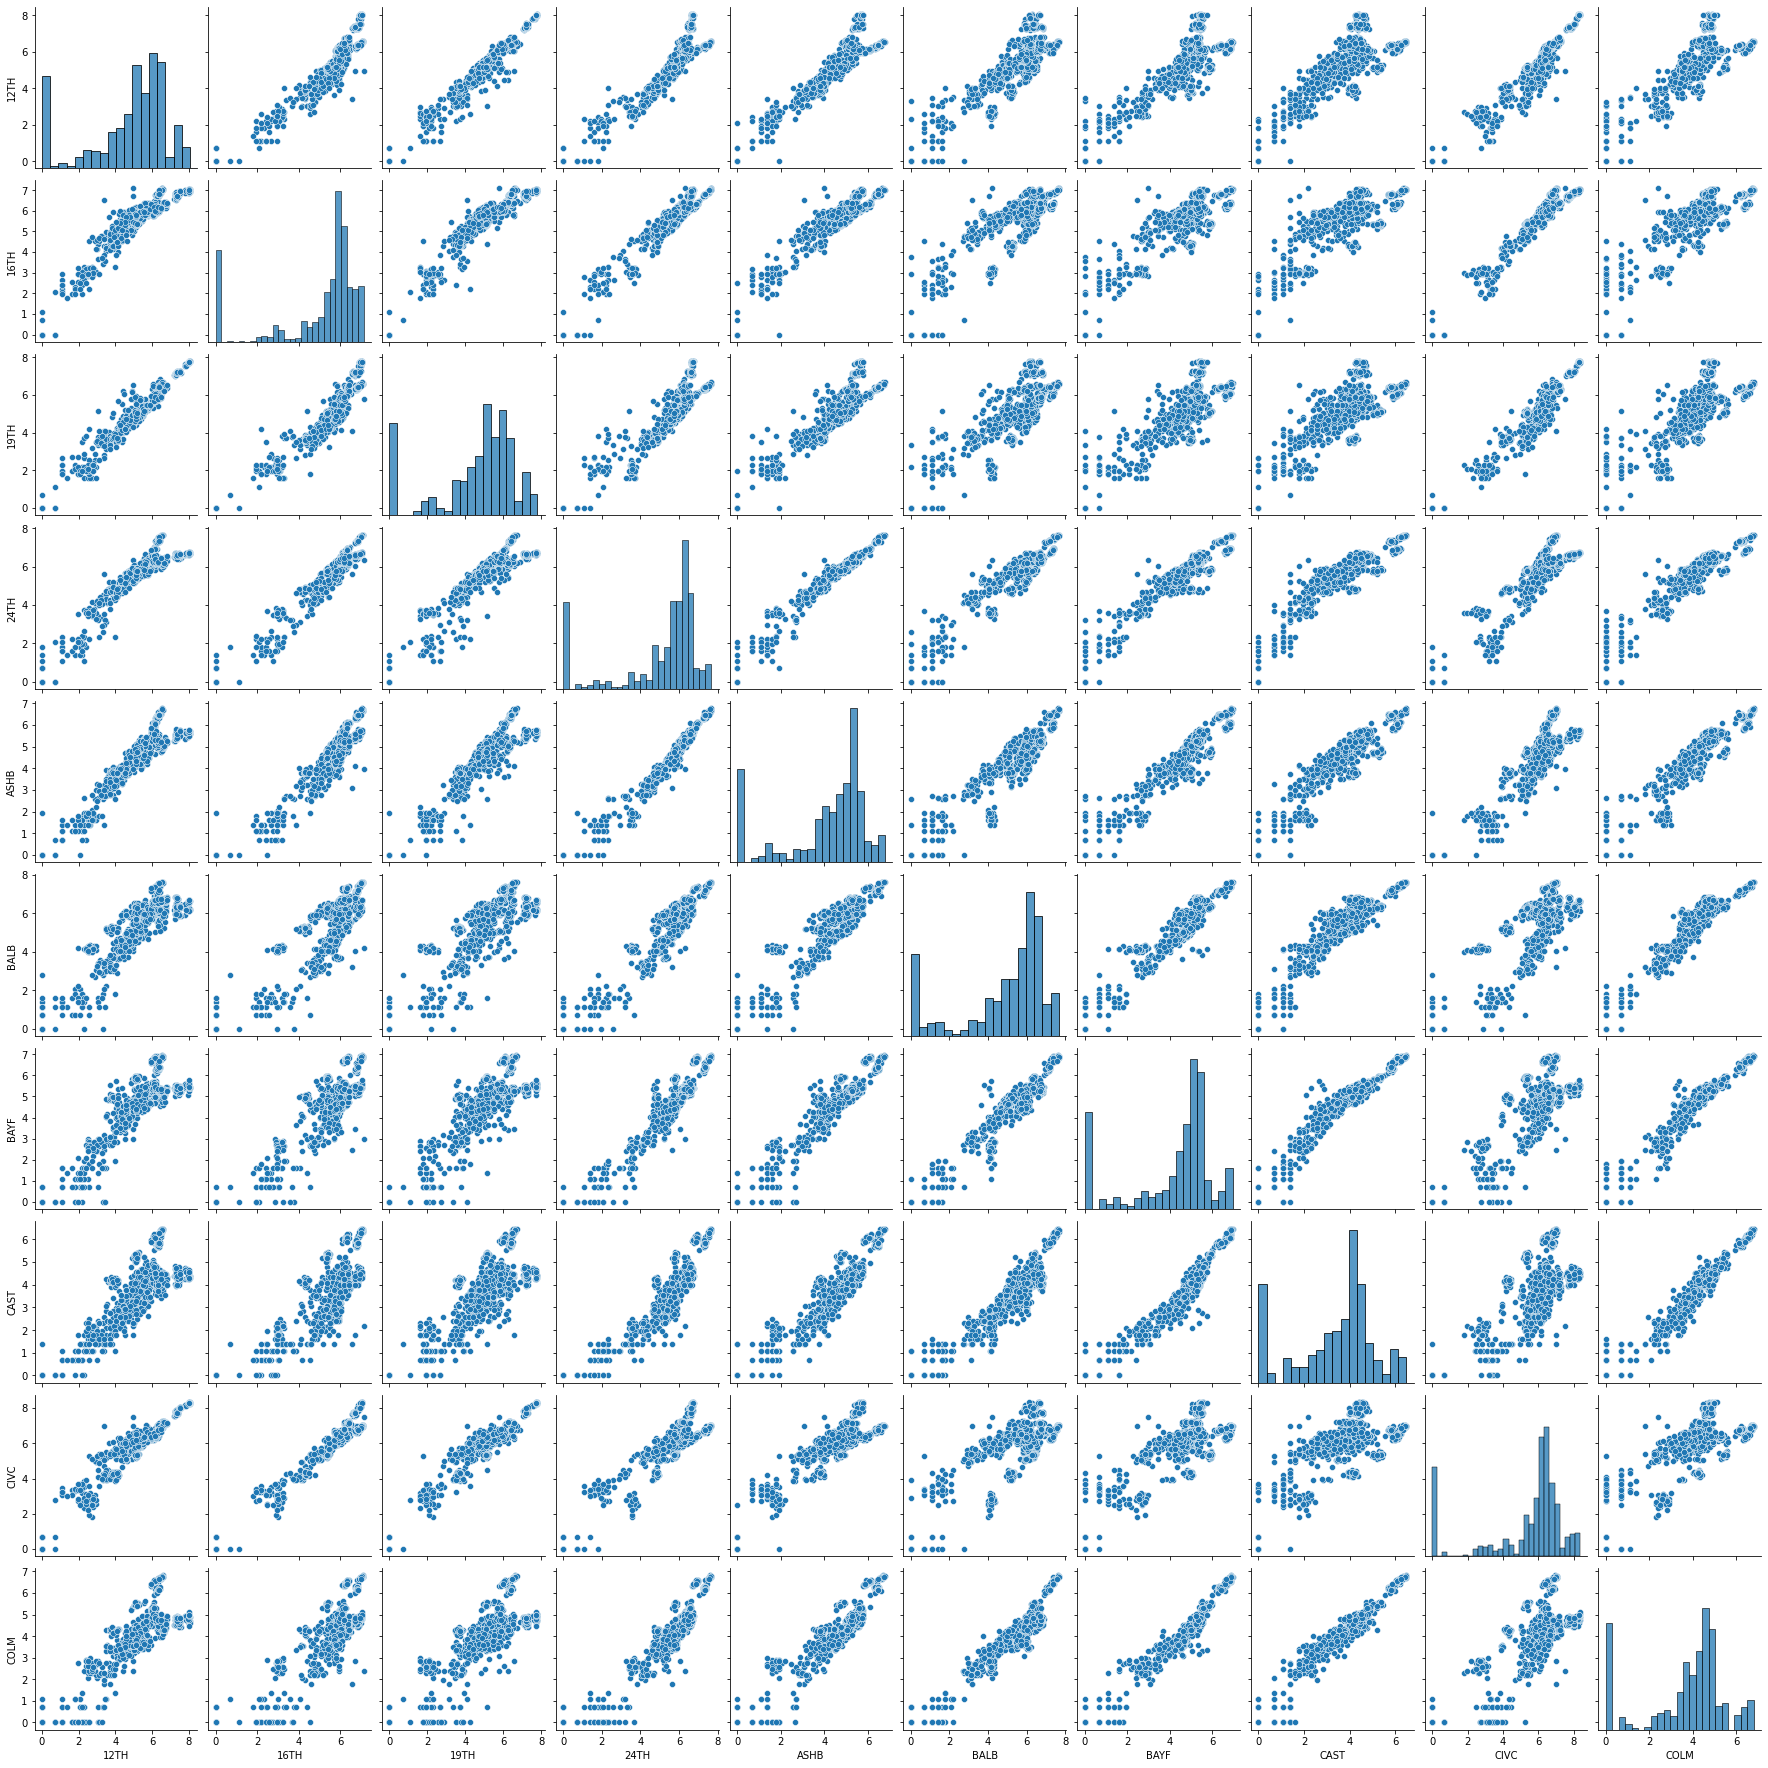

In [485]:
seaborn.pairplot(bart_df[bart_df.columns[:10]][:1000])

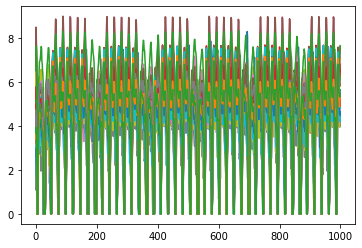

In [487]:
pyplot.plot(bart_df[:1000])
pyplot.show()

In [537]:
X = bart_df[:10000].to_numpy()
Dx = X.shape[1]

Iteration 2 - llk=-4005.0
Iteration 4 - llk=-2645.0
Iteration 6 - llk=-1267.6
Iteration 8 - llk=-761.5
Iteration 10 - llk=-608.7
Iteration 12 - llk=-547.5
Iteration 14 - llk=-506.2
Iteration 16 - llk=-472.7
Iteration 18 - llk=-444.4
Iteration 20 - llk=-420.4
Iteration 22 - llk=-399.9
Iteration 24 - llk=-382.4
Iteration 26 - llk=-367.4
Iteration 28 - llk=-354.4
Iteration 30 - llk=-342.9
Iteration 32 - llk=-332.7
Iteration 34 - llk=-323.3
Iteration 36 - llk=-314.4
Iteration 38 - llk=-306.0
Iteration 40 - llk=-297.6
Iteration 42 - llk=-289.0
Iteration 44 - llk=-279.9
Iteration 46 - llk=-270.0
Iteration 48 - llk=-258.9
Iteration 50 - llk=-246.3
Iteration 52 - llk=-232.3
Iteration 54 - llk=-217.2
Iteration 56 - llk=-202.1
Iteration 58 - llk=-187.8
Iteration 60 - llk=-175.0
Iteration 62 - llk=-163.9
Iteration 64 - llk=-154.2
Iteration 66 - llk=-145.5
Iteration 68 - llk=-137.5
Iteration 70 - llk=-130.0
Iteration 72 - llk=-122.7
Iteration 74 - llk=-115.6
Iteration 76 - llk=-108.6
Iteration 78 

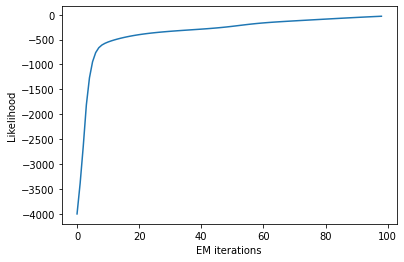

In [492]:
Dz = 4
Dx = X.shape[1]
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x=.1)
om.pca_init(X[:1000])
ssm_em_lin = StateSpaceEM(X[:1000], observation_model=om, state_model=sm, conv_crit=1e-3)
ssm_em_lin.run()
pyplot.plot(ssm_em_lin.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

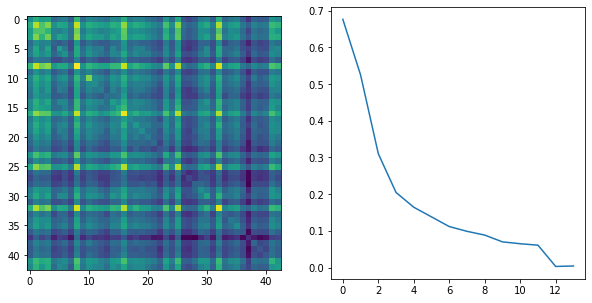

In [509]:
pyplot.figure(figsize=(10,5))
pyplot.subplot(121)
pyplot.imshow(ssm_em_lin.om.Qx)
pyplot.subplot(122)
pyplot.plot(numpy.linalg.eigvals(ssm_em_lin.om.Qx)[1:15])

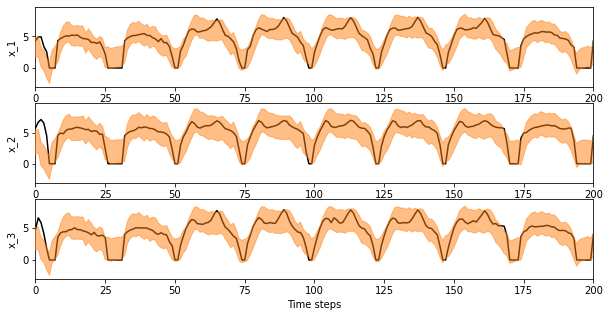

In [546]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    ix += 0
    x_min = p_x.mu[:1000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    x_max = p_x.mu[:1000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    pyplot.plot(X[:1000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,200])
pyplot.xlabel('Time steps')
pyplot.show()

In [573]:
Du = 6
Dz = 4
sm = state_models.LinearStateModel(Dz)
# Here we change the observation model.
om = observation_models.HCCovObservationModel(Dx, Dz, Du, noise_x=.1)
om.pca_init(X[:1000])
#om.U = scipy.linalg.eig(ssm_em_lin.om.Qx)[1][:,:Du]

In [574]:
ssm_em = StateSpaceEM(X[:1000], observation_model=om, state_model=sm, conv_crit=1e-3)
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

Iteration 2 - llk=-4709.1
Iteration 4 - llk=-3393.1
Iteration 6 - llk=-2841.6
Iteration 8 - llk=-2502.1
Iteration 10 - llk=-2289.8
Iteration 12 - llk=-2110.2
Iteration 14 - llk=-1982.2
Iteration 16 - llk=-1860.0
Iteration 18 - llk=-1738.5
Iteration 20 - llk=-1614.8
Iteration 22 - llk=-1520.8
Iteration 24 - llk=-1448.3
Iteration 26 - llk=-1378.0
Iteration 28 - llk=-1323.1
Iteration 30 - llk=-1291.5
Iteration 32 - llk=-1257.5
Iteration 34 - llk=-1219.9
Iteration 36 - llk=-1197.0
Iteration 38 - llk=-1166.8
Iteration 40 - llk=-1144.6
Iteration 42 - llk=-1128.2
Iteration 44 - llk=-1109.7
Iteration 46 - llk=-1079.9
Iteration 48 - llk=-1063.6
Iteration 50 - llk=-1041.3
Iteration 52 - llk=-1023.9
Iteration 54 - llk=-1013.9
Iteration 56 - llk=-1003.1
Iteration 58 - llk=-991.3
Iteration 60 - llk=-973.5
Iteration 62 - llk=-964.6


KeyboardInterrupt: 

In [578]:
numpy.dot(ssm_em.om.U.T, ssm_em.om.U), ssm_em.om.sigma_x

(array([[ 1.00002246e+00, -2.91994515e-06,  7.62181008e-06,
          2.99498602e-06, -1.90864106e-06, -2.02784216e-06],
        [-2.91994515e-06,  1.00001560e+00, -3.53284631e-06,
          2.10658980e-06,  2.83968151e-07, -1.66105998e-06],
        [ 7.62181008e-06, -3.53284631e-06,  1.00001104e+00,
         -7.15115696e-06,  4.19590291e-06,  8.92520936e-06],
        [ 2.99498602e-06,  2.10658980e-06, -7.15115696e-06,
          1.00004542e+00,  1.63270787e-05, -1.44958665e-05],
        [-1.90864106e-06,  2.83968151e-07,  4.19590291e-06,
          1.63270787e-05,  1.00004406e+00,  7.08899314e-06],
        [-2.02784216e-06, -1.66105998e-06,  8.92520936e-06,
         -1.44958665e-05,  7.08899314e-06,  1.00008288e+00]]),
 0.20075179197038895)

In [579]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    ix += 0
    x_min = p_x.mu[:1000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    x_max = p_x.mu[:1000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    pyplot.plot(X[:1000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X[:1000].shape[0]])
    pyplot.xlim([0,200])
pyplot.xlabel('Time steps')
pyplot.show()

LinAlgError: Matrix is not positive definite

In [580]:
ssm_em.compute_predictive_log_likelihood(X[1000:10000])

-52833.609883083154

In [539]:
ssm_em_lin.compute_predictive_log_likelihood(X[1000:10000])

-76029.14771604969

Text(0, 0.5, 'Log returns')

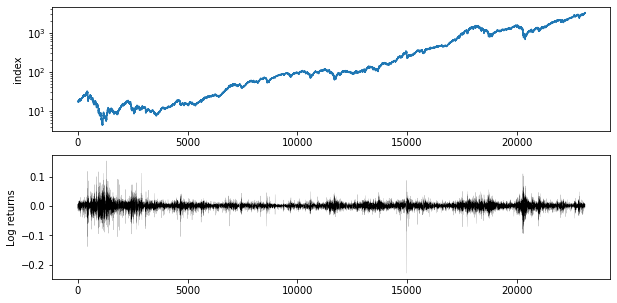

In [496]:
df = load_snp500()
dates = df.Date.to_numpy()
closing_index = df['Close'].to_numpy()
returns = numpy.log((closing_index[1:] / closing_index[:-1]))

pyplot.figure(figsize=(10,5))
pyplot.subplot(211)
pyplot.plot(closing_index)
pyplot.yscale('log')
pyplot.ylabel('index')
pyplot.subplot(212)
pyplot.plot(returns, 'k', lw=.1)
pyplot.ylabel('Log returns')

## Lorenz Attractor Example

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import solve_ivp

<ipython-input-18-24e10d7e598d>:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


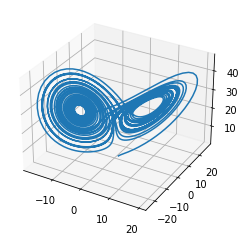

In [18]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def lorenz(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(lorenz, state0, t)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

In [19]:
from scipy.stats import zscore
X = states[100::2] 
X = zscore(X, axis=0)
X += .01 * numpy.random.randn(*X.shape)

In [20]:
Dz = 3
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz)
om.pca_init(X)

Iteration 2 - llk=-5860.2
Iteration 4 - llk=-2301.4
Iteration 6 - llk=-180.6
Iteration 8 - llk=2427.6
Iteration 10 - llk=4928.3
Iteration 12 - llk=6380.0
Iteration 14 - llk=7326.1
Iteration 16 - llk=7787.6
Iteration 18 - llk=7968.0
Iteration 20 - llk=8057.9
Iteration 22 - llk=8119.3
Iteration 24 - llk=8165.5
Iteration 26 - llk=8201.1
Iteration 28 - llk=8229.2
Iteration 30 - llk=8251.5
Iteration 32 - llk=8269.6
Iteration 34 - llk=8284.4
Iteration 36 - llk=8296.6
Iteration 38 - llk=8306.7
Iteration 40 - llk=8315.2
Iteration 42 - llk=8322.4
Iteration 44 - llk=8328.6
Iteration 46 - llk=8333.8
Iteration 48 - llk=8338.3
Iteration 50 - llk=8342.2
Iteration 52 - llk=8345.6
Iteration 54 - llk=8348.6
Iteration 56 - llk=8351.2
Iteration 58 - llk=8353.5
Iteration 60 - llk=8355.6
Iteration 62 - llk=8357.4
Iteration 64 - llk=8359.0
EM did converge.


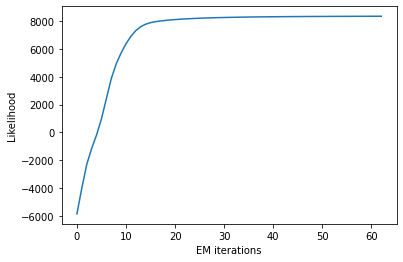

In [21]:
ssm_em_lin = StateSpaceEM(X, observation_model=om, state_model=sm)
ssm_em_lin.run()
pyplot.plot(ssm_em_lin.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

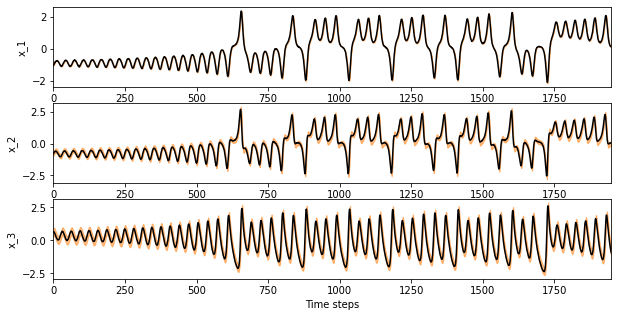

In [22]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [23]:
X_test = numpy.copy(X)
X_test[100:150] = numpy.nan
X_test[450:480] = numpy.nan
X_test[800:900] = numpy.nan
filter_test, mu, std = ssm_em_lin.predict(X_test, smoothed=True)

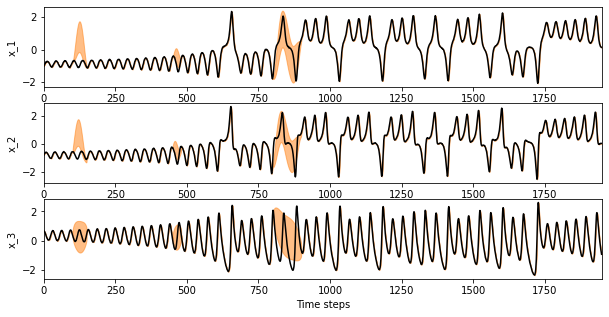

In [24]:
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [25]:
Dk = 4
Dz = 3
# Below is the only line, that changes!
sm = state_models.LSEMStateModel(Dz, Dk)
om = observation_models.LinearObservationModel(Dx, Dz)
om.pca_init(X)

Iteration 2 - llk=-5842.5
Iteration 4 - llk=-1781.2
Iteration 6 - llk=1490.3
Iteration 8 - llk=5655.1
Iteration 10 - llk=9682.4
Iteration 12 - llk=12698.1
Iteration 14 - llk=14774.5
Iteration 16 - llk=15843.2
Iteration 18 - llk=16336.5
Iteration 20 - llk=16601.3
Iteration 22 - llk=16732.7
Iteration 24 - llk=16799.0
Iteration 26 - llk=16839.3
EM did converge.


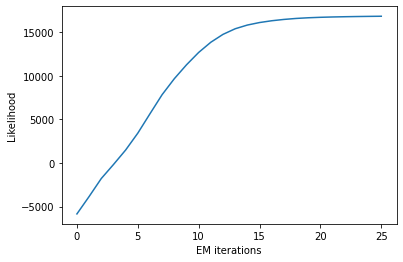

In [26]:
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm, conv_crit=1e-3)
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

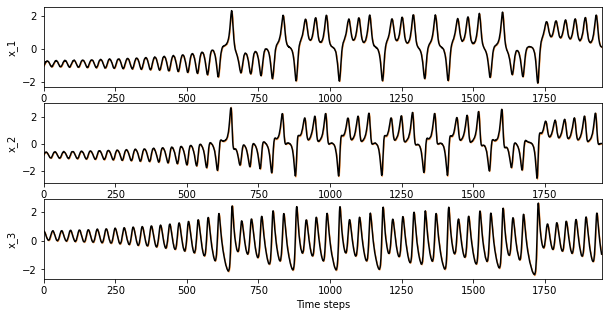

In [27]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [28]:
X_test = numpy.copy(X)
X_test[100:150] = numpy.nan
X_test[450:480] = numpy.nan
X_test[800:900] = numpy.nan
filter_test, mu, std = ssm_em.predict(X_test, smoothed=True)

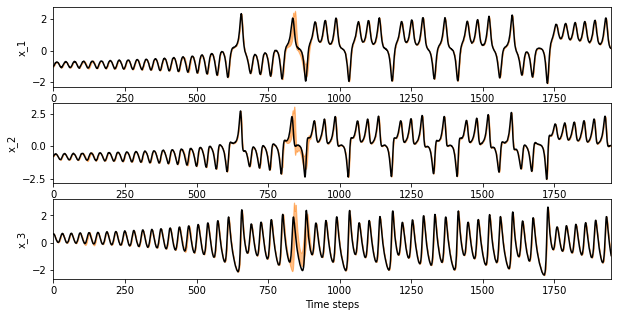

In [29]:
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()